<h1 style="text-align:center;font-size:30px;" > Quora Question Pairs similarity-Dhilip Vasanth</h1>

# 1.1 Description 


Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.


Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term. 

# Problem Statement 
1. Identify which questions asked on Quora are duplicates of questions that have already been asked. 
2. This could be useful to instantly provide answers to questions that have already been answered. 
3. We are tasked with predicting whether a pair of questions are duplicates or not. 

<h2> Sources/Useful Links</h2>

- Source : https://www.kaggle.com/c/quora-question-pairs
<br><br>____ Useful Links ____
- Discussions : https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb/comments
- Kaggle Winning Solution and other approaches: https://www.dropbox.com/sh/93968nfnrzh8bp5/AACZdtsApc1QSTQc7X0H3QZ5a?dl=0
- Blog 1 : https://engineering.quora.com/Semantic-Question-Matching-with-Deep-Learning
- Blog 2 : https://towardsdatascience.com/identifying-duplicate-questions-on-quora-top-12-on-kaggle-4c1cf93f1c30

# <h2>1.2 Real world/Business Objectives and Constraints </h2>

1. The cost of a mis-classification can be very high.
2. You would want a probability of a pair of questions to be duplicates so that you can choose any threshold of choice.
3. No strict latency concerns.
4. Interpretability is partially important.

<h3>  Data Overview </h3>
<p> 
- Data will be in a file Train.csv <br>
- Train.csv contains 5 columns : qid1, qid2, question1, question2, is_duplicate <br>
- Size of Train.csv - 60MB <br>
- Number of rows in Train.csv = 404,290
</p>

<h3> Example Data point </h3>
<pre>
"id","qid1","qid2","question1","question2","is_duplicate"
"0","1","2","What is the step by step guide to invest in share market in india?","What is the step by step guide to invest in share market?","0"
"1","3","4","What is the story of Kohinoor (Koh-i-Noor) Diamond?","What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?","0"
"7","15","16","How can I be a good geologist?","What should I do to be a great geologist?","1"
"11","23","24","How do I read and find my YouTube comments?","How can I see all my Youtube comments?","1"
</pre>

# Loading the Libraries 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc
import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import sys
import os 
import pandas as pd
import numpy as np
from tqdm import tqdm
import spacy
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve
import sqlite3
from sqlalchemy import create_engine 
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import confusion_matrix
import xgboost as xgb

C:\Users\fsdq-\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning:

The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.



# Reading data and basic stats

In [2]:
df=pd.read_csv("train.csv")
df.head()


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [3]:
print("No. of row in the dataset:{}".format(df.shape[0]))
print("No. of fetures in the dataset:{}".format(df.shape[1]))

No. of row in the dataset:404290
No. of fetures in the dataset:6


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


# Exploratory Data Analysis

<h3> Distribution of data points among output classes</h3>
- Number of duplicate(smilar) and non-duplicate(non similar) questions

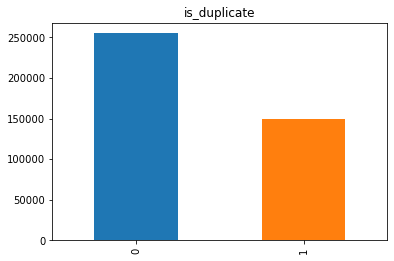

In [5]:
df.is_duplicate.value_counts().plot(kind="bar",title="is_duplicate")

In [6]:
print("question pair are not similar(is_duplicate=0):{}%".format(100-round(df["is_duplicate"].mean()*100,2)))
print("question pair are similar(is_duplicate=1):{}%".format(round(df["is_duplicate"].mean()*100,2)))

question pair are not similar(is_duplicate=0):63.08%
question pair are similar(is_duplicate=1):36.92%


### observation:

Therefore most of the class label are not duplicate thus the dataset shows it is imbalance the distribution of dissimilar question is higher than the similar questions

<h3>Number of unique questions </h3>

In [7]:
qids=pd.Series(df["qid1"].tolist()+df["qid2"].tolist())
len_qids=len(qids)
unique_question=len(np.unique(qids))
print("no. of unique question in the dataset:{}({}%)".format(unique_question,np.round(unique_question/len_qids*100)))

no. of unique question in the dataset:537933(67.0%)


In [8]:
question_more_than_one_time=np.sum(qids.value_counts()>1)
question_more_than_one_time

print("No. of question repeated more than one times:{} ({}%)".format(question_more_than_one_time,np.round(question_more_than_one_time/unique_question*100,2)))

No. of question repeated more than one times:111780 (20.78%)


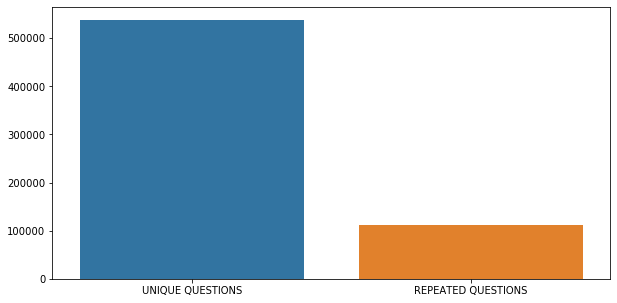

In [9]:
X=["UNIQUE QUESTIONS","REPEATED QUESTIONS"]
Y=[unique_question,question_more_than_one_time]

plt.figure(figsize=(10,5))
sns.barplot(X,Y)
plt.show()

<h3>Checking for pair Duplicates </h3>

In [10]:
pair_duplicates = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()
print("No. of duplicate pairs:{}".format(pair_duplicates.shape[0]-df.shape[0]))

No. of duplicate pairs:0


<h3>Number of occurrences of each question </h3>

Maximum number of times a single question is repeated: 157



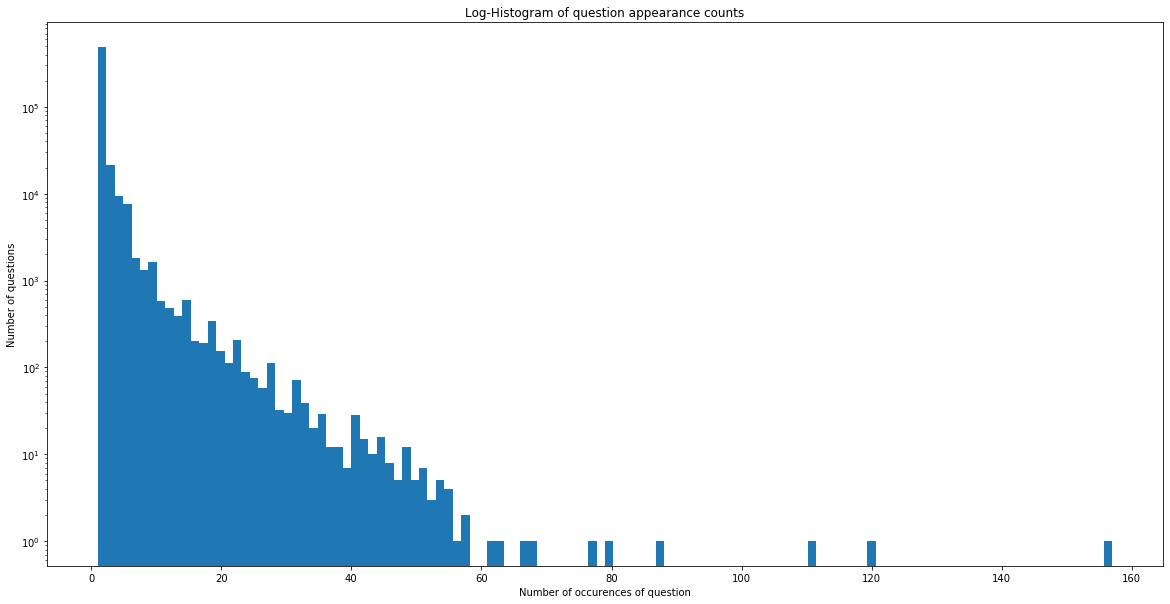

In [11]:
plt.figure(figsize=(20, 10))

plt.hist(qids.value_counts(), bins=120)

plt.yscale('log', nonposy='clip')

plt.title('Log-Histogram of question appearance counts')

plt.xlabel('Number of occurences of question')

plt.ylabel('Number of questions')

print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

<h3>Checking for NULL values </h3>

In [12]:
null_value=df[df.isnull().any(1)]
null_value

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


In [14]:
# df=df.fillna("")
nan_rows=df[df.isnull().any(1)]
nan_rows

,id,qid1,qid2,question1,question2,is_duplicate


# Feature Engineering(Basic Features,Advance Features,Text features)

<h2>Basic Feature Extraction (before cleaning) </h2>

Let us now construct a few features like:
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

In [14]:
df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count') 
df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')

In [15]:
df["q1len"]=df["question1"].str.len()
df["q2len"]=df["question2"].str.len()

In [16]:
df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

In [17]:
def word_common(row):
    w1=set(map(lambda word:word.lower().strip(),row["question1"].split(" ")))
    w2=set(map(lambda word:word.lower().strip(),row["question2"].split(" ")))
    return len(w1&w2)
df["word_common"]=df.apply(word_common,axis=1)

In [18]:
def word_total(row):
    w1=set(map(lambda word:word.lower().strip(),row["question1"].split(" ")))
    w2=set(map(lambda word:word.lower().strip(),row["question2"].split(" ")))
    return len(w1)+len(w2)

df["word_total"]=df.apply(word_total,axis=1)



In [19]:
def word_share(row):
    w1=set(map(lambda word:word.lower().strip(),row["question1"].split(" ")))
    w2=set(map(lambda word:word.lower().strip(),row["question2"].split(" ")))
    return len(w1&w2)/(len(w1)+len(w2))
    
df["word_share"]=df.apply(word_share,axis=1)

In [20]:
df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])

In [21]:
column=list(df)
column.insert(17,column.pop(column.index("is_duplicate")))
column
df=df.ix[:,column]
df.head()

C:\Users\fsdq-\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated



,id,qid1,qid2,question1,question2,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_common,word_total,word_share,freq_q1+q2,freq_q1-q2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,1,1,66,57,14,12,10,23,0.434783,2,0,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,4,1,51,88,8,13,4,20,0.200000,5,3,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,1,1,73,59,14,10,4,24,0.166667,2,0,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,1,1,50,65,11,9,0,19,0.000000,2,0,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,3,1,76,39,13,7,2,20,0.100000,4,2,0


<h3>Analysis of some of the basic extracted features </h3>

In [22]:
print("Minimum length of the question in question1:{}".format(min(df["q1_n_words"])))
print("Minimum length of the question in question2:{}".format(min(df["q2_n_words"])))

Minimum length of the question in question1:1
Minimum length of the question in question2:1


In [23]:
print("Minimum length of the question in question1:{}".format(max(df["q1_n_words"])))
print("Minimum length of the question in question2:{}".format(max(df["q2_n_words"])))

Minimum length of the question in question1:125
Minimum length of the question in question2:237


In [24]:
print("Number of question with the minimum length in question1:{}".format(df[df["q1_n_words"]==min(df["q1_n_words"])].shape[0]))
print("Number of question with the maximum length in question2:{}".format(df[df["q2_n_words"]==min(df["q2_n_words"])].shape[0]))

Number of question with the minimum length in question1:67
Number of question with the maximum length in question2:24


In [25]:
print("Number of question with the minimum length in question1:{}".format(df[df["q1_n_words"]==max(df["q1_n_words"])].shape[0]))
print("Number of question with the maximum length in question2:{}".format(df[df["q2_n_words"]==max(df["q2_n_words"])].shape[0]))

Number of question with the minimum length in question1:1
Number of question with the maximum length in question2:13


<h4>Feature: word_share </h4>

C:\Users\fsdq-\Anaconda3\lib\site-packages\seaborn\distributions.py:218: MatplotlibDeprecationWarning:


The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.

C:\Users\fsdq-\Anaconda3\lib\site-packages\seaborn\distributions.py:218: MatplotlibDeprecationWarning:


The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.



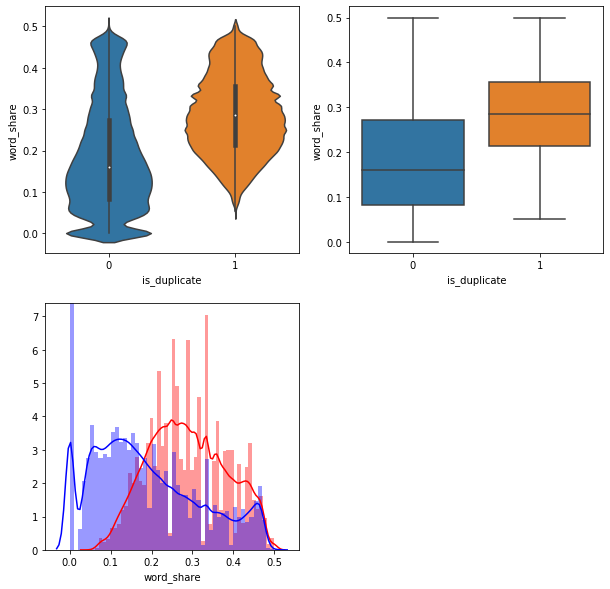

In [26]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
sns.violinplot(x=df["is_duplicate"],y=df["word_share"])
plt.subplot(2,2,2)
sns.boxplot(x=df["is_duplicate"],y=df["word_share"])
plt.subplot(2,2,3)
sns.distplot(df[df["is_duplicate"]==1]["word_share"][0:],label=1,color='red')
sns.distplot(df[df["is_duplicate"]==0]["word_share"][0:],label=0,color="blue")
plt.show()

<h4>Feature: word_common </h4>

C:\Users\fsdq-\Anaconda3\lib\site-packages\seaborn\distributions.py:218: MatplotlibDeprecationWarning:


The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.

C:\Users\fsdq-\Anaconda3\lib\site-packages\seaborn\distributions.py:218: MatplotlibDeprecationWarning:


The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.



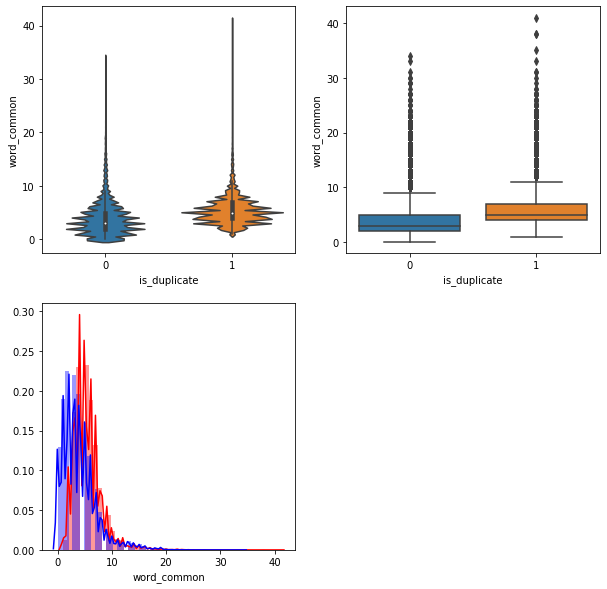

In [27]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
sns.violinplot(x=df["is_duplicate"],y=df["word_common"])
plt.subplot(2,2,2)
sns.boxplot(x=df["is_duplicate"],y=df["word_common"])
plt.subplot(2,2,3)
sns.distplot(df[df["is_duplicate"]==1]["word_common"][0:],label=1,color='red')
sns.distplot(df[df["is_duplicate"]==0]["word_common"][0:],label=0,color="blue")
plt.show()

<h4>Feature: word_total </h4>

C:\Users\fsdq-\Anaconda3\lib\site-packages\seaborn\distributions.py:218: MatplotlibDeprecationWarning:


The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.

C:\Users\fsdq-\Anaconda3\lib\site-packages\seaborn\distributions.py:218: MatplotlibDeprecationWarning:


The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.



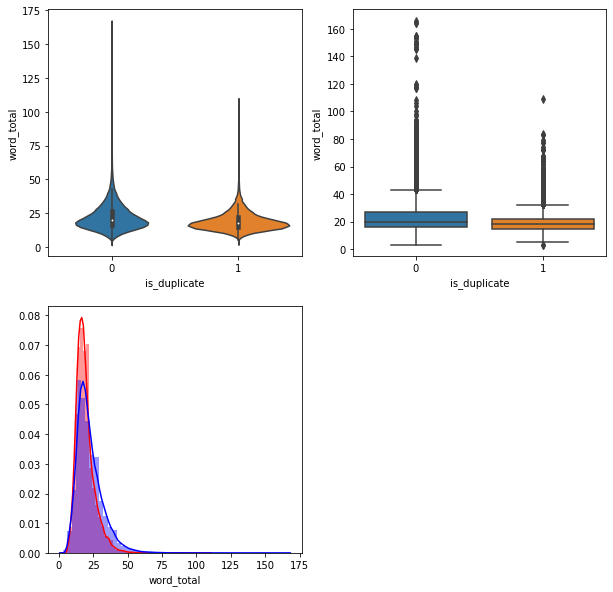

In [28]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
sns.violinplot(x=df["is_duplicate"],y=df["word_total"])
plt.subplot(2,2,2)
sns.boxplot(x=df["is_duplicate"],y=df["word_total"])
plt.subplot(2,2,3)
sns.distplot(df[df["is_duplicate"]==1]["word_total"][0:],label=1,color='red')
sns.distplot(df[df["is_duplicate"]==0]["word_total"][0:],label=0,color="blue")
plt.show()

# Preprocessing of Text 

 - Preprocessing:
    - Removing html tags 
    - Removing Punctuations
    - Performing stemming
    - Removing Stopwords
    - Expanding contractions etc.

In [29]:
SAFE_DIV = 0.0001 

stop_words = stopwords.words("english")
from nltk.tokenize import word_tokenize

def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
        
    
    return x
    

## Advanced Feature Extraction (NLP and Fuzzy Features)

Definition:
- __Token__: You get a token by splitting sentence a space
- __Stop_Word__ : stop words as per NLTK.
- __Word__ : A token that is not a stop_word


Features:
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>
<br>
- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>
<br>
- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>
<br>
- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>
<br>
- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
<br>

- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>
<br>
        
- __last_word_eq__ :  Check if First word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>
<br>

- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>
<br>
        
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>
<br>

- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>
<br>


- __fuzz_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>

- __fuzz_partial_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_sort_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_set_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>





- __longest_substr_ratio__ :  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))


In [30]:
def tokenize_word(q1,q2):
    token_features=[0.0]*10
    q1_tokenize=q1.split()
    q2_tokenize=q2.split()
    
    q1_words=set([word for word in q1_tokenize if word not in stop_words])
    q2_words=set([word for word in q2_tokenize if word not in stop_words])
    
    q1_stopwords=set([word for word in q1_tokenize if word in stop_words])
    q2_stopwords=set([word for word in q2_tokenize if word in stop_words])
    
    common_word_count=len(q1_words.intersection(q2_words))
    common_stopword_count=len(q1_stopwords.intersection(q2_words))
    common_tokenize_count=len(set(q1_tokenize).intersection(q2_tokenize))
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stopword_count / (min(len(q1_stopwords), len(q2_stopwords)) + SAFE_DIV)
    token_features[3] = common_stopword_count / (max(len(q1_stopwords), len(q2_stopwords)) + SAFE_DIV)
    token_features[4] = common_tokenize_count / (min(len(q1_tokenize), len(q2_tokenize)) + SAFE_DIV)
    token_features[5] = common_tokenize_count / (max(len(q1_tokenize), len(q2_tokenize)) + SAFE_DIV)
    token_features[6] = int(q1_tokenize[-1] == q2_tokenize[-1])
    token_features[7] = int(q1_tokenize[0] == q2_tokenize[0])
    token_features[8] = abs(len(q1_tokenize) - len(q2_tokenize))
    token_features[9] = (len(q1_tokenize) + len(q2_tokenize))/2
    
    return token_features
def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    df["question1"]=preprocess(df["question1"].fillna(""))
    df["question2"]=preprocess(df["question2"].fillna(""))
    token_features=df.apply(lambda x:tokenize_word(x["question1"],x["question2"]),axis=1)
    
    df["cwc_min"]=list(map(lambda x:x[0],token_features))
    df["cwc_max"]=list(map(lambda x:x[1],token_features))
    df["csc_min"]= list(map(lambda x: x[2], token_features))
    df["csc_max"]= list(map(lambda x: x[3], token_features))
    df["ctc_min"]= list(map(lambda x: x[4], token_features))
    df["ctc_max"]= list(map(lambda x: x[5], token_features))
    df["last_word_eq"]= list(map(lambda x: x[6], token_features))
    df["first_word_eq"]= list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]= list(map(lambda x: x[8], token_features))
    df["mean_len"]= list(map(lambda x: x[9], token_features))
    df["fuzz_ratio"]=df.apply(lambda x:fuzz.QRatio(x["question1"],x["question2"]),axis=1)
    df["fuzz_partial_ratio"]=df.apply(lambda x:fuzz.partial_ratio(x["question1"],x["question2"]),axis=1)
    df["fuzz_token_sort_ratio"]=df.apply(lambda x:fuzz.token_sort_ratio(x["question1"],x["question2"]),axis=1)
    df["fuzz_token_set_ratio"]=df.apply(lambda x:fuzz.token_set_ratio(x["question1"],x["question2"]),axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    
    return df

In [31]:
import pandas as pd
df=pd.read_csv("nlp_features_train.csv",encoding='latin-1')
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,0.399992,0.333328,0.399992,0.249997,...,0.285712,0.0,1.0,4.0,12.0,66,66,54,54,0.166667
3,3,7,8,why am i mentally very lonely how can i solve...,find the remainder when math 23 24 math i...,0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,2.0,12.0,36,36,35,40,0.039216
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,0.399992,0.199998,0.999950,0.666644,...,0.307690,0.0,1.0,6.0,10.0,67,47,46,56,0.175000


## Analysis on advanced features

- Creating Word Cloud of Duplicates and Non-Duplicates Question pairs
- We can observe the most frequent occuring words

In [32]:
df_duplicate=df[df["is_duplicate"]==1]
df_notduplicate=df[df["is_duplicate"]==0]

duplicate=np.dstack([df_duplicate["question1"],df_duplicate["question2"]]).flatten()
not_duplicate=np.dstack([df_notduplicate["question1"],df_notduplicate["question2"]]).flatten()

print("No. of duplicate question:",len(duplicate))
print("No. of nonduplicate question:",len(not_duplicate))


No. of duplicate question: 298526
No. of nonduplicate question: 510054


In [33]:
duplicate_words=[]
not_duplicate_words=[]
stopwords=set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")
stopwords.remove("no")

stopwords.remove("like")

for i in duplicate:
    duplicateword=i.split()
    for j in duplicateword:
        if j not in stopwords:
            duplicate_words.append(j)
    
print("No. of duplicate words in duplicate pair of question:{}".format(len(duplicate_words)))    

No. of duplicate words in duplicate pair of question:1449499


__ Word Clouds generated from  duplicate pair question's text __

Word Cloud for Duplicate Question pairs


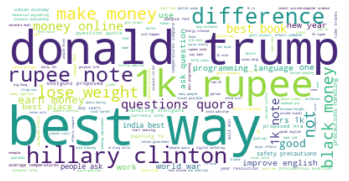

In [34]:
duplicatestring="-".join(map(str,duplicate_words))
wc = WordCloud(background_color="white", max_words=len(duplicatestring), stopwords=stopwords)
wc.generate(duplicatestring)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

### Pair plot of features ['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio']

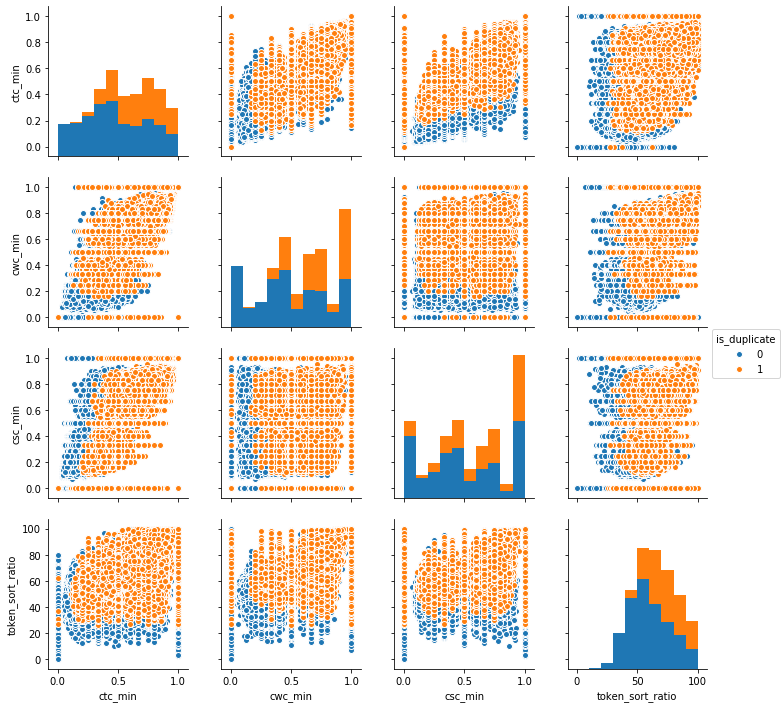

In [35]:
n = df.shape[0]
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

### Pair plot of features ['ctc_max', 'cwc_max', 'csc_max', 'token_sort_ratio']

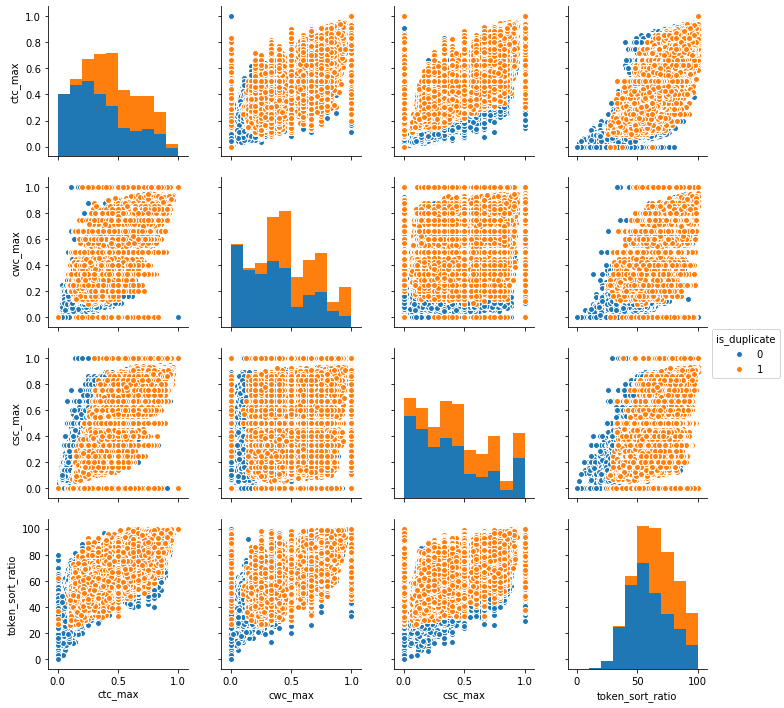

In [36]:
n = df.shape[0]
sns.pairplot(df[['ctc_max', 'cwc_max', 'csc_max', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_max', 'cwc_max', 'csc_max', 'token_sort_ratio'])
plt.show()

C:\Users\fsdq-\Anaconda3\lib\site-packages\seaborn\distributions.py:218: MatplotlibDeprecationWarning:


The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.

C:\Users\fsdq-\Anaconda3\lib\site-packages\seaborn\distributions.py:218: MatplotlibDeprecationWarning:


The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.



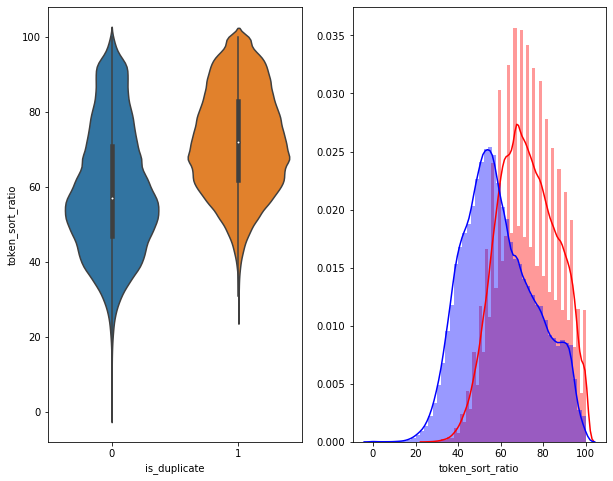

In [37]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

C:\Users\fsdq-\Anaconda3\lib\site-packages\seaborn\distributions.py:218: MatplotlibDeprecationWarning:


The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.

C:\Users\fsdq-\Anaconda3\lib\site-packages\seaborn\distributions.py:218: MatplotlibDeprecationWarning:


The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.



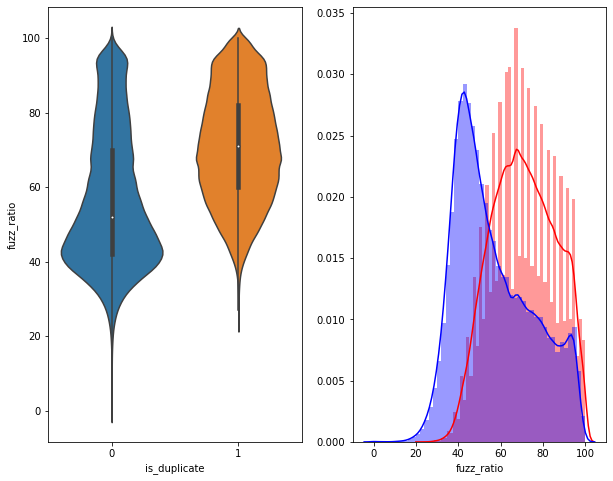

In [38]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

C:\Users\fsdq-\Anaconda3\lib\site-packages\seaborn\distributions.py:218: MatplotlibDeprecationWarning:


The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.

C:\Users\fsdq-\Anaconda3\lib\site-packages\seaborn\distributions.py:218: MatplotlibDeprecationWarning:


The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.



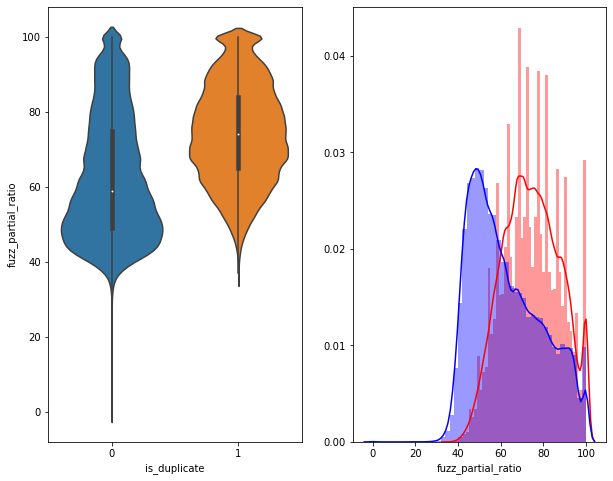

In [39]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_partial_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['fuzz_partial_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['fuzz_partial_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

## Data Visualization

In [40]:
from sklearn.preprocessing import MinMaxScaler
df_sample=df[0:50000]
x=MinMaxScaler().fit_transform(df_sample[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y=df_sample["is_duplicate"].values

tsne2d=TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(x)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 50000 samples in 2.525s...
[t-SNE] Computed neighbors for 50000 samples in 28.964s...
[t-SNE] Computed conditional probabilities for sample 1000 / 50000
[t-SNE] Computed conditional probabilities for sample 2000 / 50000
[t-SNE] Computed conditional probabilities for sample 3000 / 50000
[t-SNE] Computed conditional probabilities for sample 4000 / 50000
[t-SNE] Computed conditional probabilities for sample 5000 / 50000
[t-SNE] Computed conditional probabilities for sample 6000 / 50000
[t-SNE] Computed conditional probabilities for sample 7000 / 50000
[t-SNE] Computed conditional probabilities for sample 8000 / 50000
[t-SNE] Computed conditional probabilities for sample 9000 / 50000
[t-SNE] Computed conditional probabilities for sample 10000 / 50000
[t-SNE] Computed conditional probabilities for sample 11000 / 50000
[t-SNE] Computed conditional probabilities for sample 12000 / 50000
[t-SNE] Computed conditional probabilities for sa

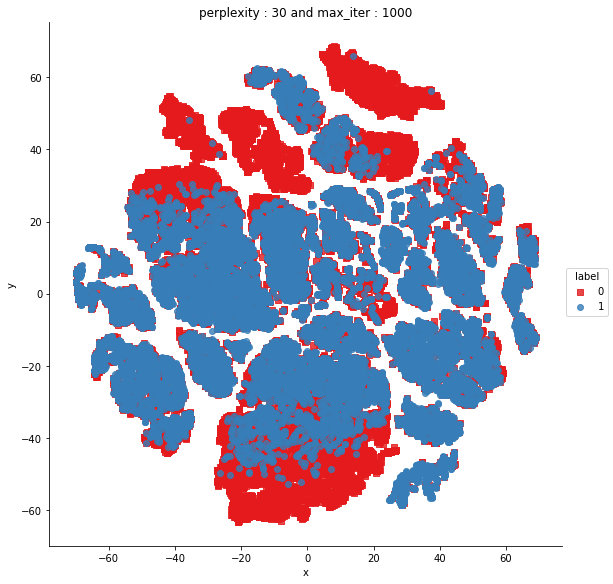

In [41]:
df1= pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=df1, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

## Text Features

### TFIDF weighted word2vec

In [42]:
df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))
questions1= list(df['question1']) 
questions2= list(df['question2'])
tfidf = TfidfVectorizer(lowercase=False,ngram_range=(1,3),min_df=0.000032)
count=CountVectorizer()
quest1tfidf=tfidf.fit_transform(questions1)
quest2tfidf=tfidf.fit_transform(questions2)
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

In [43]:
import en_core_web_sm
nlp = en_core_web_sm.load()

vecs1 = []
for qu1 in tqdm(list(df['question1'])):
    doc1 = nlp(qu1) 
    mean_vec1 = np.zeros([len(doc1),384])
    for word1 in doc1:
        vec1 = word1.vector
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
df['q1_feats_m'] = list(vecs1)

100%|████████████████████████████████████████████████████████████████████████| 404290/404290 [1:21:35<00:00, 82.58it/s]


In [44]:
vecs2 = []
for qu2 in tqdm(list(df['question2'])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc2),384])
    for word2 in doc2:
        vec2 = word2.vector
        try:
            idf = word2tfidf[str(word2)]
        except:
            idf = 0
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
df['q2_feats_m'] = list(vecs2)



100%|█████████████████████████████████████████████████████████████████████████| 404290/404290 [59:48<00:00, 112.65it/s]


In [45]:
dfnlp = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
dfppro = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
df1 = dfnlp.drop(['qid1','qid2','question1','question2'],axis=1)
df2 = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3 = df.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3_q1 = pd.DataFrame(df3.q1_feats_m.values.tolist(), index= df3.index)
df3_q2 = pd.DataFrame(df3.q2_feats_m.values.tolist(), index= df3.index)

In [48]:
df3_q1['id']=df1['id']
df3_q2['id']=df1['id']
df1  = df1.merge(df2, on='id',how='left')
df2  = df3_q1.merge(df3_q2, on='id',how='left')
result  = df1.merge(df2, on='id',how='left')
result.to_csv('final_features1.csv')

In [46]:
if not os.path.isfile('final_features.csv'):
    df3_q1['id']=df1['id']
    df3_q2['id']=df1['id']
    df1  = df1.merge(df2, on='id',how='left')
    df2  = df3_q1.merge(df3_q2, on='id',how='left')
    result  = df1.merge(df2, on='id',how='left')
    result.to_csv('final_features.csv')

In [9]:
df_set1=pd.read_csv("final_features.csv")

In [10]:
yset1=df_set1["is_duplicate"].values
yset1

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [11]:
dfset1=df_set1.drop("is_duplicate",axis=1)
dfset1.head()

,Unnamed: 0,id,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,...,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
0,0,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,...,-60.006229,77.306409,12.635764,91.978675,-1.074855,-17.797457,104.623968,-121.373514,3.462948,-10.377327
1,1,1,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,...,-138.233825,44.236732,-90.939461,72.336899,-130.247097,76.594143,62.762860,-173.081567,78.653270,-22.284909
2,2,2,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,...,-103.864767,91.211648,25.567267,-7.207038,-49.312985,-9.452115,41.286228,-12.136122,18.111080,17.218847
3,3,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,-181.471177,13.326730,114.351416,-28.014818,-51.088904,-59.292729,75.607714,-55.300985,1.687277,-54.490450
4,4,4,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,...,8.036099,32.631671,-50.962523,36.893881,-3.491007,17.218764,82.496744,-75.725498,46.642821,-20.948222


In [12]:
dfset1.shape

(404290, 220)

### Tfidf vectorizer

In [7]:
df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))
questions1= list(df['question1']) 
questions2= list(df['question2'])
tfidf = TfidfVectorizer(lowercase=False,ngram_range=(1,3),min_df=10,max_features=500)
count=CountVectorizer()
quest1tfidf=tfidf.fit_transform(questions1).toarray()
quest2tfidf=tfidf.fit_transform(questions2).toarray()
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

In [8]:
dfnlp = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
dfppro = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')

In [9]:
df1 = dfnlp.drop(['qid1','qid2','question1','question2'],axis=1)
df2 = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3 = df.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
dfq1=pd.DataFrame(quest1tfidf,columns=[i for i in range(len(quest1tfidf[1]))])
dfq2 =pd.DataFrame(quest2tfidf,columns=[i for i in range(len(quest2tfidf[1]))])

In [ ]:
dfq1['id']=df1['id']
dfq2['id']=df1['id']
df1  = df1.merge(df2, on='id',how='left')
df2  = dfq1.merge(dfq2, on='id',how='left')
result  = df1.merge(df2, on='id',how='left')
result.to_csv("finaltfidfvec.csv",header=False,index=False)

In [25]:
dftfidf=pd.read_csv("final_tfidffeatures.csv")

In [26]:
yset2=dftfidf["is_duplicate"].values
yset2

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [27]:
dfset2=dftfidf.drop("is_duplicate",axis=1)
dfset2.head()

,Unnamed: 0,id,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,...,490_y,491_y,492_y,493_y,494_y,495_y,496_y,497_y,498_y,499_y
0,0,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,2,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,4,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
dfset2.shape

(404290, 1039)

# Random train test split( 70:30)

## Train Test split in set1

In [13]:
X_trainset1,X_testset1, y_trainset1, y_testset1 = train_test_split(dfset1, yset1, stratify=yset1, test_size=0.3)
X_trainset1,X_cvset1,y_trainset1,y_cvset1=train_test_split(X_trainset1,y_trainset1,stratify=y_trainset1,test_size=0.3)

In [14]:
X_trainset1.shape

(198102, 220)

In [15]:
X_testset1.shape

(121287, 220)

In [16]:
len(y_trainset1)

198102

In [17]:
len(y_testset1)

121287

In [18]:
X_cvset1.shape

(84901, 220)

In [19]:
y_cvset1.shape

(84901,)

## Train Test Split in set2

In [20]:
X_trainset2,X_testset2, y_trainset2, y_testset2 = train_test_split(dfset2, yset2, stratify=yset2, test_size=0.3)
X_trainset2,X_cvset2,y_trainset2,y_cvset2=train_test_split(X_trainset2,y_trainset2,stratify=y_trainset2,test_size=0.3)

In [21]:
X_trainset2.shape

(198102, 1039)

In [22]:
X_testset2.shape

(121287, 1039)

In [23]:
X_cvset2.shape

(84901, 1039)

In [24]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

# Model implementation for set1 features

## Logistic Regression with hyperparameter tuning

For values of alpha =  1e-05 The log loss is: 0.6585257001467676
For values of alpha =  0.0001 The log loss is: 0.6585257001467676
For values of alpha =  0.001 The log loss is: 0.6585257001467676
For values of alpha =  0.01 The log loss is: 0.6585257001467676
For values of alpha =  0.1 The log loss is: 0.5866444494901306
For values of alpha =  1 The log loss is: 0.5971697872347081
For values of alpha =  10 The log loss is: 0.5972334968010728


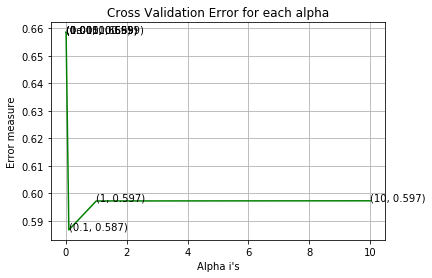

For values of alpha =  6 The log loss is: 0.5863262626319682


In [24]:
alpha = [10 ** x for x in range(-5, 2)] 
log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42,n_jobs=1,max_iter=1000)
    clf.fit(X_trainset1, y_trainset1)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_trainset1, y_trainset1)
    predict_y = sig_clf.predict_proba(X_cvset1)
    log_error_array.append(log_loss(y_cvset1, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cvset1, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf.fit(X_trainset1, y_trainset1)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_trainset1, y_trainset1)
predict_y=sig_clf.predict_proba(X_testset1)
log_loss(y_testset1,predict_y,labels=clf.classes_,eps=1e-15)
print('For values of alpha = ', i, "The log loss is:",log_loss(y_testset1, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.1 The train log loss is: 0.5860917186200131
For values of best alpha =  0.1 The test log loss is: 0.5863262626319682
Total number of data points : 121287


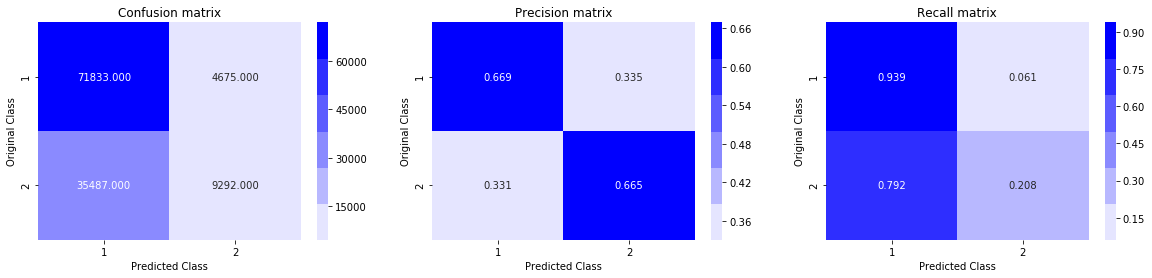

In [25]:
predict_y = sig_clf.predict_proba(X_trainset1)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_trainset1, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_testset1)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_testset1, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_testset1, predicted_y)

## Linear SVM with hyperparameter tuning

In [25]:
alpha = [10 ** x for x in range(-5, 2)] 
log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42,max_iter=10000,n_jobs=-1)
    clf.fit(X_trainset1, y_trainset1)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_trainset1, y_trainset1)
    predict_y = sig_clf.predict_proba(X_cvset1)
    log_error_array.append(log_loss(y_cvset1, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cvset1, predict_y, labels=clf.classes_, eps=1e-15))

For values of alpha =  1e-05 The log loss is: 0.6585257001467676
For values of alpha =  0.0001 The log loss is: 0.6585257001467676
For values of alpha =  0.001 The log loss is: 0.6585257001467676
For values of alpha =  0.01 The log loss is: 0.6585257001467676
For values of alpha =  0.1 The log loss is: 0.6585257001467676
For values of alpha =  1 The log loss is: 0.6585257001467676


C:\Users\fsdq-\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.



For values of alpha =  10 The log loss is: 0.6585257001467676


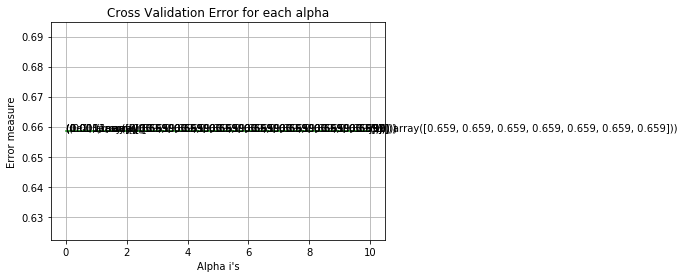

In [26]:
fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(log_error_array,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

For values of best alpha =  1e-05 The train log loss is: 0.6585278354206578
For values of best alpha =  1e-05 The test log loss is: 0.6585278257233967
Total number of data points : 121287


C:\Users\fsdq-\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning:

invalid value encountered in true_divide



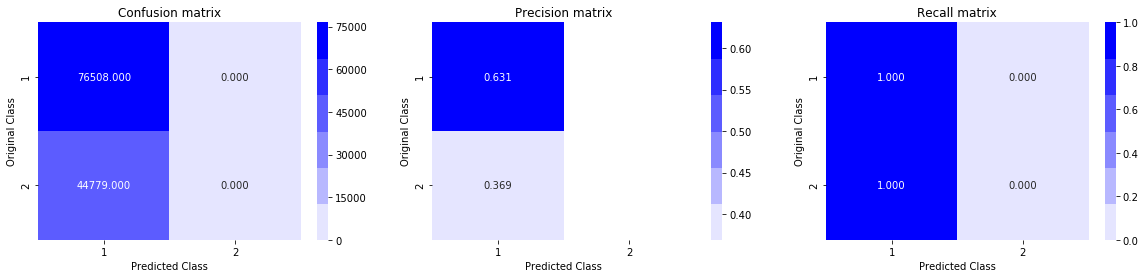

In [27]:
best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_trainset1, y_trainset1)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_trainset1, y_trainset1)
predict_y=sig_clf.predict_proba(X_testset1)
log_loss(y_testset1,predict_y,labels=clf.classes_,eps=1e-15)
predict_y = sig_clf.predict_proba(X_trainset1)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_trainset1, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_testset1)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_testset1, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_testset1, predicted_y)

## XGboost 

In [28]:
estimator=[100,150,200,250,300]
depth=[3,4,5,6,7]
train_log_loss_array=[]
for i,j in zip(estimator,depth):
    clf=xgb.XGBClassifier(n_estimator=i,max_depth=j,n_jobs=-1)
    clf.fit(X_trainset1,y_trainset1)
    predict_y = clf.predict_proba(X_cvset1)
    train_log_loss_array.append(log_loss(y_cvset1, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cvset1, predict_y, labels=clf.classes_, eps=1e-15))

For values of alpha =  100 The log loss is: 0.34274696868316484
For values of alpha =  150 The log loss is: 0.3353013857915579
For values of alpha =  200 The log loss is: 0.331302749364552
For values of alpha =  250 The log loss is: 0.32998338368070335
For values of alpha =  300 The log loss is: 0.32876268916540846


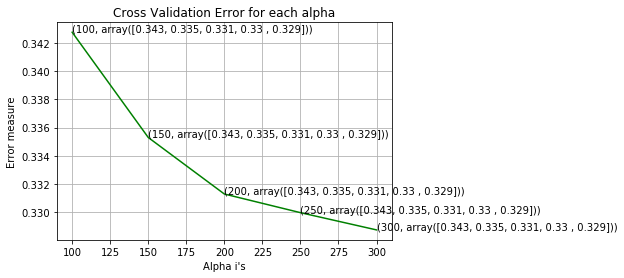

In [29]:
fig, ax = plt.subplots()
ax.plot(estimator, train_log_loss_array,c='g')
for i, txt in enumerate(np.round(train_log_loss_array,3)):
    ax.annotate((estimator[i],np.round(train_log_loss_array,3)), (estimator[i],train_log_loss_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

For values of best alpha =  300 The train log loss is: 0.26686505555427426
For values of best alpha =  300 The test log loss is: 0.33819973810469645
Total number of data points : 121287


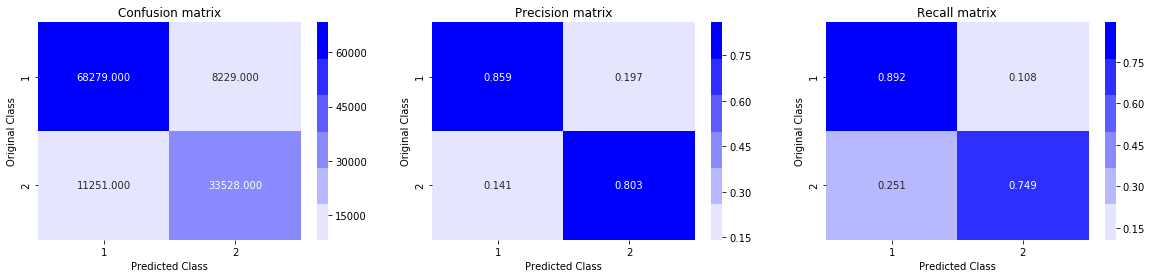

In [30]:
best_alpha = np.argmin(train_log_loss_array)
clf = xgb.XGBClassifier(n_estimator=best_alpha, penalty='l2', loss='log', random_state=42)
clf.fit(X_trainset1, y_trainset1)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_trainset1, y_trainset1)
predict_y=sig_clf.predict_proba(X_testset1)
log_loss(y_testset1,predict_y,labels=clf.classes_,eps=1e-15)
predict_y = sig_clf.predict_proba(X_trainset1)
log_loss(y_trainset1,predict_y,labels=clf.classes_,eps=1e-15)
print('For values of best alpha = ', estimator[best_alpha], "The train log loss is:",log_loss(y_trainset1, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_testset1)
print('For values of best alpha = ', estimator[best_alpha], "The test log loss is:",log_loss(y_testset1, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_testset1, predicted_y)

# Model implementation for set2

## Logistic Regression with hyperparameter tuning

For values of alpha =  1e-05 The log loss is: 0.6585257001467676
For values of alpha =  0.0001 The log loss is: 0.6585257001467676
For values of alpha =  0.001 The log loss is: 0.6585257001467676
For values of alpha =  0.01 The log loss is: 0.6585257001467676
For values of alpha =  0.1 The log loss is: 0.622883323509627
For values of alpha =  1 The log loss is: 0.6075936893581104
For values of alpha =  10 The log loss is: 0.6106702454204487


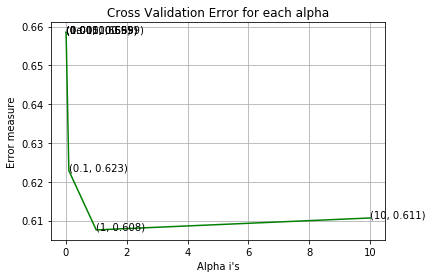

For values of best alpha =  1 The train log loss is: 0.6084025888009968
For values of best alpha =  1 The test log loss is: 0.607669379423082
Total number of data points : 121287


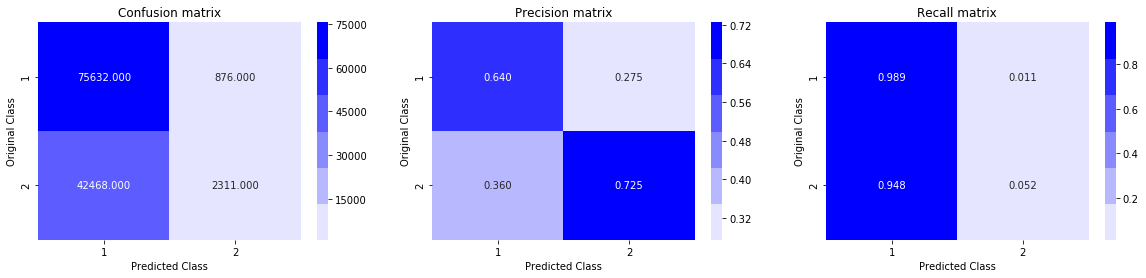

In [28]:
alpha = [10 ** x for x in range(-5, 2)] 
log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42,n_jobs=1,max_iter=1000)
    clf.fit(X_trainset2, y_trainset2)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_trainset2, y_trainset2)
    predict_y = sig_clf.predict_proba(X_cvset2)
    log_error_array.append(log_loss(y_cvset2, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cvset2, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_trainset2, y_trainset2)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_trainset2, y_trainset2)

predict_y = sig_clf.predict_proba(X_trainset2)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_trainset2, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_testset2)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_testset2, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_testset2, predicted_y)

## Linear SVM with hyperparameter tuning

In [31]:
alpha=[10**x for x in range(-5,2)]
log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42,max_iter=1000,n_jobs=-1)
    clf.fit(X_trainset2, y_trainset2)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_trainset2, y_trainset2)
    predict_y = sig_clf.predict_proba(X_cvset2)
    log_error_array.append(log_loss(y_cvset2, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cvset2, predict_y, labels=clf.classes_, eps=1e-15))


For values of alpha =  1e-05 The log loss is: 0.6585257001467677
For values of alpha =  0.0001 The log loss is: 0.6585257001467677
For values of alpha =  0.001 The log loss is: 0.6585257001467677
For values of alpha =  0.01 The log loss is: 0.6585257001467677
For values of alpha =  0.1 The log loss is: 0.6585257001467677


C:\Users\fsdq-\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.



For values of alpha =  1 The log loss is: 0.5850395994225337


C:\Users\fsdq-\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.



For values of alpha =  10 The log loss is: 0.6585080395112861


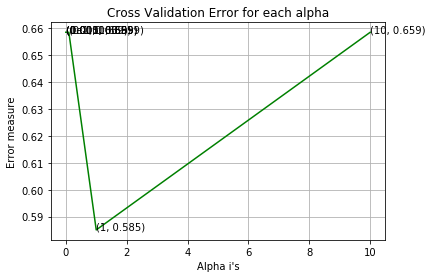

In [32]:
fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

C:\Users\fsdq-\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.



For values of best alpha =  1 The train log loss is: 0.5840625313844425
For values of best alpha =  1 The test log loss is: 0.5846163110664682
Total number of data points : 121287


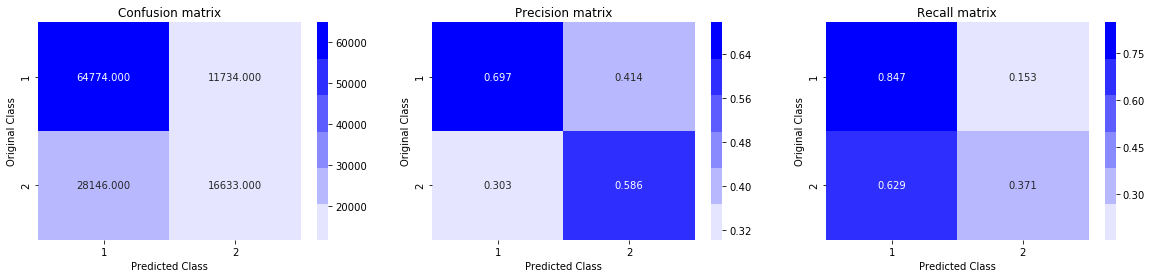

In [33]:
best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_trainset2, y_trainset2)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_trainset2, y_trainset2)
predict_y=sig_clf.predict_proba(X_testset2)
log_loss(y_testset2,predict_y,labels=clf.classes_,eps=1e-15)
predict_y = sig_clf.predict_proba(X_trainset2)
log_loss(y_trainset1,predict_y,labels=clf.classes_,eps=1e-15)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_trainset2, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_testset2)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_testset2, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_testset2, predicted_y)

## XGboost

In [34]:
estimator=[100,150,200,250,300]
depth=[3,4,5,6,7]
train_log_loss_array=[]
for i,j in zip(estimator,depth):
    clf=xgb.XGBClassifier(n_estimator=i,max_depth=j,n_jobs=-1)
    clf.fit(X_trainset2,y_trainset2)
    predict_y = clf.predict_proba(X_cvset2)
    train_log_loss_array.append(log_loss(y_cvset2, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cvset2, predict_y, labels=clf.classes_, eps=1e-15))


For values of alpha =  100 The log loss is: 0.337294777333358
For values of alpha =  150 The log loss is: 0.32880925272093103
For values of alpha =  200 The log loss is: 0.3225702178251512
For values of alpha =  250 The log loss is: 0.31845395189616466
For values of alpha =  300 The log loss is: 0.3144778635958085


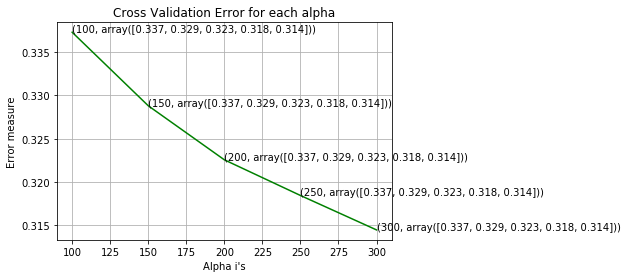

In [35]:
fig, ax = plt.subplots()
ax.plot(estimator, train_log_loss_array,c='g')
for i, txt in enumerate(np.round(train_log_loss_array,3)):
    ax.annotate((estimator[i],np.round(train_log_loss_array,3)), (estimator[i],train_log_loss_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

## Conclusion

In [8]:
from prettytable import PrettyTable
x=PrettyTable()
x.field_names=["Si.no.","features","model","Log-Loss"]
x.add_row(["1","set1-features","Logistic Regression","0.5863"])
x.add_row(["2","set1-features","linear-SVM","0.6585"])
x.add_row(["3","set1-features","Xgboost","0.3381"])
x.add_row(["4","set2-features","Logistic Regression","0.6076"])
x.add_row(["5","set2-features","Linear-SVM","0.5846"])
x.add_row(["6","set2-features","XGboost","0.3184"])
print(x)

+--------+---------------+---------------------+----------+
| Si.no. |    features   |        model        | Log-Loss |
+--------+---------------+---------------------+----------+
|   1    | set1-features | Logistic Regression |  0.5863  |
|   2    | set1-features |      linear-SVM     |  0.6585  |
|   3    | set1-features |       Xgboost       |  0.3381  |
|   4    | set2-features | Logistic Regression |  0.6076  |
|   5    | set2-features |      Linear-SVM     |  0.5846  |
|   6    | set2-features |       XGboost       |  0.3184  |
+--------+---------------+---------------------+----------+


## Step by step followed in this case study

1. First understanding the bussiness problems and had an idea of applying the machine learning technique.
2. Understand the dataset given for the problem end to end.
3. Applied some of the data analysis on the dataset and also find whether the class is balanced or imbalanced and also checking null values
4. Applied Feature Engineering and we splitted into three groups 
   1. Basic Features
   2. Advance Features(fuzzy features)finding the similarity of the text
   3. Text Features(TFIDFW2v,TFIDF)
5. Finally we split up into two sets of features
   1. set1--> Basic features+Advance Features+TFIDFw2v
   2. set2--> Basic features+Advance Features+TFIDF
6. Finally we applied three model on each sets of features
   1. Logistic Regression
   2. Linear SVM
    c. XGBoost
7. finally by the above result we can say that Xgboost perform well by comparing the above two model.
   1. set1--> Xgboost logloss is 0.3381
   2. set2--> Xgboost logloss is 0.3184